# 시계열 데이터 분석(정석)

ACF plot과 PACF plot을 통해 모수를 추정하여 차분을 수행하여 분석하는 방법

In [1]:
from pandas import read_excel
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sb
import sys

In [3]:
# 영국 왕 수명 데이터 
# 앞 예제를 통해 데이터가 비정상성임을 확인함
df = read_excel("https://data.hossam.kr/E06/kings.xlsx")
df.head()

,age
0,60
1,43
2,67
3,50
4,56


In [4]:
plt.rcParams['font.family'] = "Malgun Gothic"
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['axes.unicode_minus'] = False

# 3. ACF, PACF 검정


정상 시계열 데이터의 경우 ACF는 상대적으로 빠르게 0(상관관계 0)에 접근한다.

비정상 시계열 데이터의 경우 ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

| 구분 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |
|---|---|---|
| ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다. |
| PACF plot | 첫 값으로부터 $p$개 뒤에 끊긴다. | 천천히 감소 |





### ACF Plot 과 PACK Plot

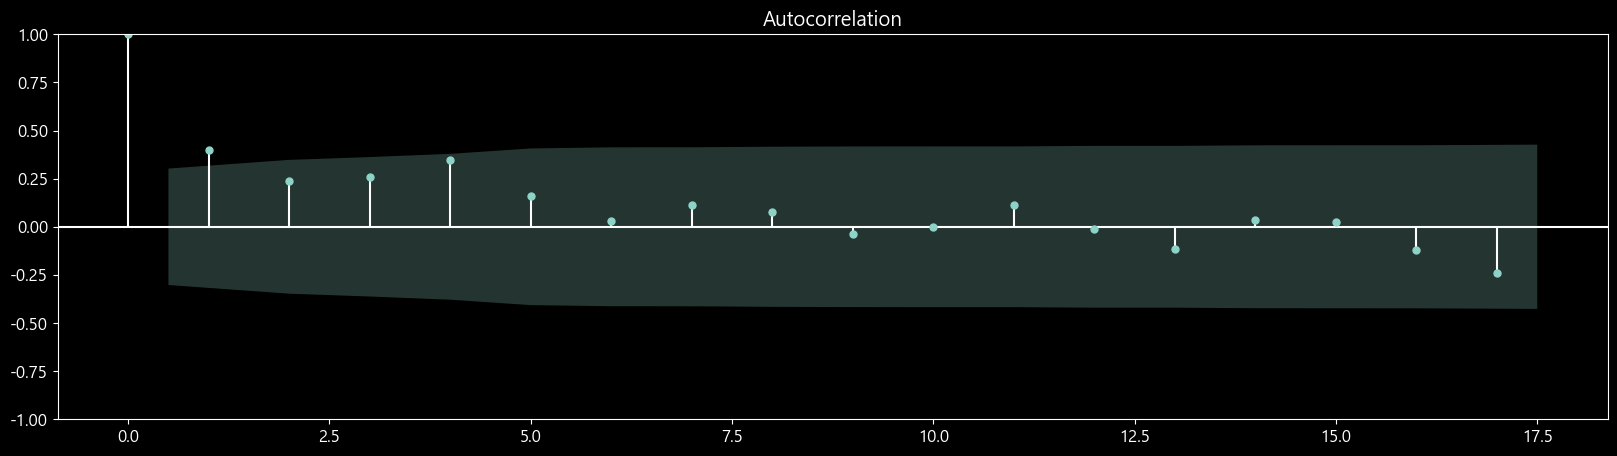

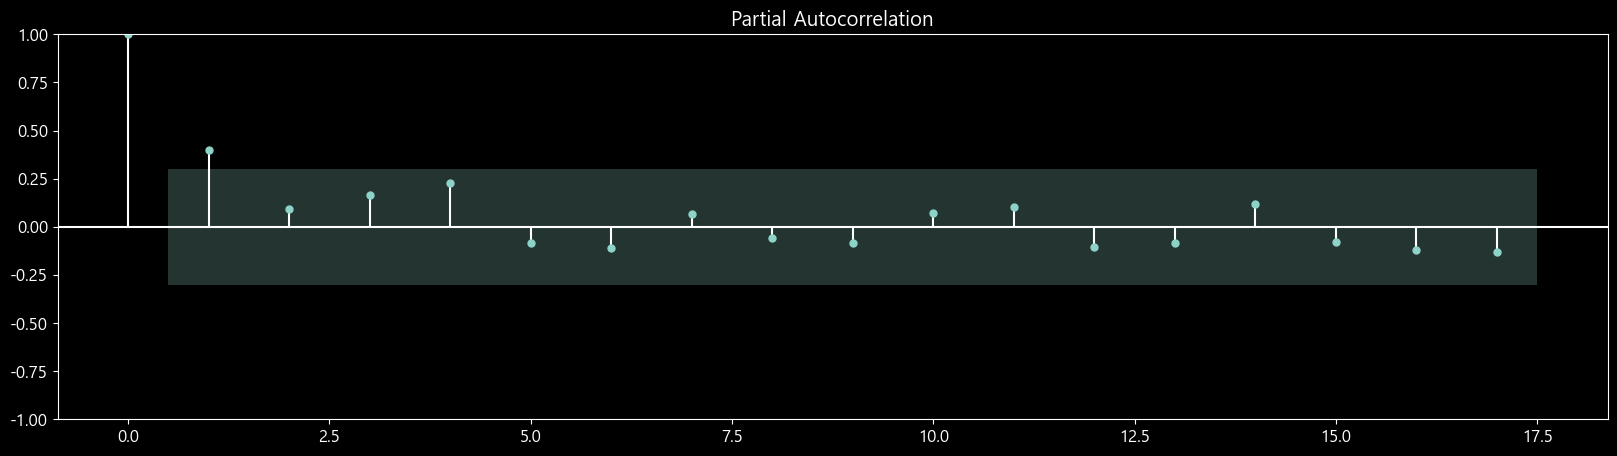

In [7]:
plot_acf(df)
plot_pacf(df)
plt.show()
plt.close()

결과 판정

이 결과를 고려하여 완만함을 보이는 PACF 플롯 채택 $MA(1)$ 모델로 결정
| 구분 | ACF plot | PACF plot |
|---|---|---|
| 감소 | 상대적으로 급격 | 상대적으로 완만 |
| 파란박스 진입 지점 | $p=1$ | $q=1$ |


### 원본 데이터에 대한 ADF 테스트

ACF,PACF Plot으로 적용할 모델을 결정한다면, 차분을 몇 번 수행하는 것이 좋을지 결정해야 한다.

| 모델 | 의미 |
|---|---|
| $AR(n)$ | $ARIMA(p,d,q)$ 중에서 $p=n, q=0$이라는 의미 |
| $MA(n)$ | $ARIMA(p,d,q)$ 중에서 $p=0, q=n$이라는 의미 |


ADF 테스트의 결과로 차분의 횟수가 결정되면 이 값이 d를 의미함


#### ADF 테스트의 가설
| 가설 | 내용 |
|---|---|
| 귀무가설 | 데이터가 정상성과 다르다 (=비정상성임을 의미) |
| 대립가설 | 데이터가 정상성이다. |


In [9]:
ar = adfuller(df)
print('ADF Statistic : %f' % ar[0])
print('p-value : %f' % ar[1])
print('num of lags : %f' % ar[2])
print('num of observation : %f' % ar[3])
print('Critical Values :')
for key, value in ar[4].items() :
    print('\t%s: %.3f' %(key,value))


ADF Statistic : -4.090230
p-value : 0.001005
num of lags : 0.000000
num of observation : 41.000000
Critical Values :
	1%: -3.601
	5%: -2.935
	10%: -2.606


p-value가 0.5보다 작으므로 귀무가설을 기각해도 대립가설 채택, 즉 예제 데이터는 정상성 데이터

만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행

대립가설이 채택될 때까지 이 과정을 반복함

반복횟수가 $d$ 값이 됨

> 이 예제는 1> 이 예제에서는 1번의 차분은 수행해야 한다고 가정함

## 3. 차분 수행

In [10]:
diff1 = df.diff().dropna()
diff1.head()

,age
1,-17.0
2,24.0
3,-17.0
4,6.0
5,-14.0


### 차분 결과로 ADF 테스트 다시 수행

In [12]:
ar = adfuller(diff1)

print('ADF Statistic : %f' % ar[0])
print('p-value : %f' % ar[1])
print('num of lags : %f' % ar[2])
print('num of observation : %f' % ar[3])
print('Critical Values :')
for key, value in ar[4].items() :
    print('\t%s: %.3f' %(key,value))

ADF Statistic : -6.300508
p-value : 0.000000
num of lags : 2.000000
num of observation : 38.000000
Critical Values :
	1%: -3.616
	5%: -2.941
	10%: -2.609


## 4. ARIMA 분석 수행